# Imports

In [ ]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import random

from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [ ]:
# import data
df = pd.read_csv('ARTISTS_data.csv')

# Data Exploration

In [ ]:
# counts
print(len(df['userID'].unique()))
print(len(df['artistID'].unique()))
df

1870
2774


,userID,artistID,name,Label,IR,BR
0,781,5475,Blue Foundation,0,0.008757,0.000198
1,1772,6543,Millionaires,0,0.009731,0.000137
2,1323,507,Saosin,0,0.085817,0.000807
3,1427,11206,The Black Dog,1,0.000921,0.000067
4,18,10672,Voivod,0,0.009281,0.000204
...,...,...,...,...,...,...
80055,1332,3575,Blake Lewis,1,0.057420,0.000618
80056,718,1507,Omarion,0,0.005333,0.000092
80057,106,2896,Albert Collins,0,0.006839,0.000156
80058,1582,396,L'Arc~en~Ciel,0,0.007817,0.000198


In [ ]:
print(len(df.loc[df['Label'] == 1]))
print(len(df.loc[df['Label'] == 0]))

31353
48707


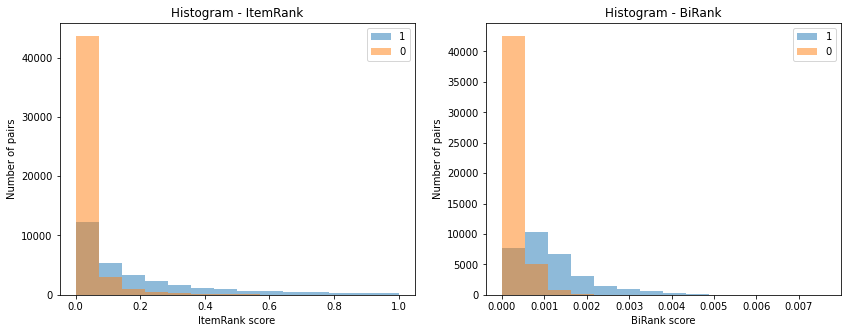

<function matplotlib.pyplot.tight_layout>

In [ ]:
#visualize data 
plt.figure(figsize=(14, 5)) 

plt.subplot(1,2,1)
#bins = np.linspace(0, max(df['IR']), 15)
bins = np.linspace(0, 1, 15)
plt.hist(df['IR'].loc[df['Label'] == 1].values,bins, alpha=0.5, label='1')
plt.hist(df['IR'].loc[df['Label'] == 0].values,bins, alpha=0.5, label='0')
plt.ylabel('Number of pairs')
plt.xlabel('ItemRank score')
plt.legend(loc='upper right')
plt.title('Histogram - ItemRank')


plt.subplot(1,2,2)
bins = np.linspace(0, max(df['BR']), 15)
plt.hist(df['BR'].loc[df['Label'] == 1].values,bins, alpha=0.5, label='1')
plt.hist(df['BR'].loc[df['Label'] == 0].values,bins, alpha=0.5, label='0')
plt.ylabel('Number of pairs')
plt.xlabel('BiRank score')
plt.legend(loc='upper right')
plt.title('Histogram - BiRank')

plt.show()
plt.tight_layout

# Binary Classification

# IR vs BR

In [ ]:
# # create X
# X = np.array(df['IR']).reshape(-1, 1)
# X.shape

# create X
X = np.array(df['BR']).reshape(-1, 1)
X.shape

# create y
y = np.array(df['Label'])
y.shape

(80060,)

In [ ]:
# divide data into training and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

print(X_train.shape)
print(X_test.shape)
# check for distribution of y
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

(64048, 1)
(16012, 1)
0.3916125405945541
0.391643767174619


## Logistic Regression

**Model Selection**

In [ ]:
# Grid Search for optimal parameters with CV
# round1
parameter_grid = {
              'C': [0.001,0.01,0.1,1,10,50,100,500]
}

grid = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=parameter_grid,verbose=2, n_jobs=10, cv = 5
)

grid.fit(X_train, y_train)
print("Best accuracy: %f with params %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:    7.9s finished


Best accuracy: 0.792577 with params {'C': 500}


In [ ]:
# train and fit model
model_LR = LogisticRegression(C = 500)
model_LR.fit(X_train, y_train)
print("Traning accuracy for Linear Regression: {}".format(model_LR.score(X_train, y_train)))

Traning accuracy for Linear Regression: 0.7981982263302523


**Evaluation**

Testing accuracy: 0.7982762927804147
Sensitivity = 0.5509488119917079
Specificity = 0.9574992300585156
Logistic Regression: ROC AUC = 0.890


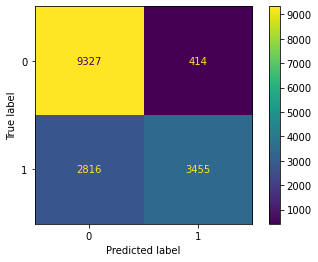

In [ ]:
# TEST DATA
# score
print('Testing accuracy: '+str(model_LR.score(X_test, y_test) ))
# confusion matrix
plot_confusion_matrix(model_LR,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['0','1'])

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, model_LR.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

# ROC AUC
print('Logistic Regression: ROC AUC = %.3f' % (roc_auc_score(y_test, model_LR.predict_proba(X_test)[:, 1])))

## SVC

**Model Selection**

In [ ]:
# Grid Search for optimal parameters with CV
pipe_classifier = Pipeline([('scaler',  StandardScaler()),
            ('SVC', svm.SVC())])
parameter_grid = [{
              'SVC__C': [0.1, 0.5, 1], 
              'SVC__kernel': ['rbf', 'linear'],
              'SVC__gamma': [0.01,0.1,'auto',10]
}]


grid = GridSearchCV (estimator = pipe_classifier,
                               param_grid = parameter_grid,
                               scoring='roc_auc',cv = 5, verbose=2, n_jobs=10)
grid.fit(X_train, y_train)
print("Best score AUC: %f with params %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 19.1min
[Parallel(n_jobs=10)]: Done 120 out of 120 | elapsed: 95.2min finished


Best score AUC: 0.886962 with params {'SVC__C': 0.5, 'SVC__gamma': 0.01, 'SVC__kernel': 'rbf'}


In [ ]:
# train and fit model
svc = svm.SVC(C=0.5, gamma=0.01,kernel='rbf', probability=True)
svc.fit(X_train, y_train)
print("Traning accuracy for SVC: {}".format(svc.score(X_train, y_train)))

Traning accuracy for SVC: 0.6083874594054459


**Evaluation**

Testing accuracy for SVC: 0.608356232825381
Sensitivity = 0.0
Specificity = 1.0
SVC: ROC AUC = 0.890


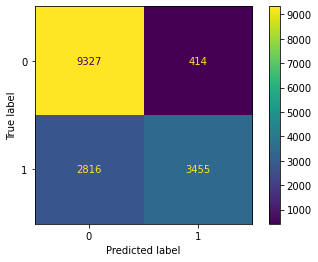

In [ ]:
# TEST DATA
# score
print('Testing accuracy for SVC: '+str(svc.score(X_test, y_test) ))
# confusion matrix
# confusion matrix
plot_confusion_matrix(model_LR,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['0','1'])

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, svc.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

# ROC AUC
print('SVC: ROC AUC = %.3f' % (roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1])))

## Random Forest

**Model Selection**

In [ ]:
# Grid Search for optimal parameters with CV
# round1
parameter_grid = {
              'n_estimators': [10,25,50,75,100], 
              'max_depth': [1,2,3,4,5]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=parameter_grid,
    scoring='roc_auc', verbose=2, n_jobs=10, cv = 5
)

grid.fit(X_train, y_train)
print("Best score AUC: %f with params %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   19.7s
[Parallel(n_jobs=10)]: Done 125 out of 125 | elapsed:  2.5min finished


Best score AUC: 0.840655 with params {'max_depth': 4, 'n_estimators': 100}


In [ ]:
# train and fit model
rfc = RandomForestClassifier(n_estimators=100, max_depth=4)
rfc.fit(X_train, y_train)

print("Traning accuracy for Random Forest: {}".format(rfc.score(X_train, y_train)))

Traning accuracy for Random Forest: 0.7873001498875843


**Evaluation**

Testing accuracy:  0.790407194604047


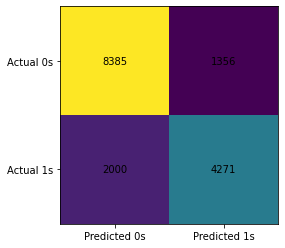

Sensitivity = 0.6810715994259289
Specificity = 0.8607945796119495
RFC: ROC AUC = 0.842


In [ ]:
# TEST DATA
# score
print('Testing accuracy:  '+str(rfc.score(X_test, y_test) ))
# confusion matrix
plot_confusion_matrix(model_LR,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['0','1'])
# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, rfc.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

# ROC AUC
print('RFC: ROC AUC = %.3f' % (roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])))

## XGBoost

**Model selection**

In [ ]:
# Grid Search for optimal parameters with CV
# round1
parameter_grid = {
              'learning_rate': [0.1, 0.5, 1], 
              'max_depth': [3,6,10],
              'gamma': [0, 1, 5],
              'reg_lambda': [0, 1.0, 10.0],
              'scale_pos_weight': [1, 2, 3] # for imbalanced data
}

grid = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=15,
                                subsample=0.8,
                                ),
    param_grid=parameter_grid,
    scoring='roc_auc', 
    verbose=2, #0 otherwise
    n_jobs=10,
    cv = 5
)

grid.fit(X_train, y_train)
print("Best score AUC: %f with params %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   41.5s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  5.2min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed: 11.6min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed: 21.7min
[Parallel(n_jobs=10)]: Done 993 tasks      | elapsed: 34.4min
[Parallel(n_jobs=10)]: Done 1215 out of 1215 | elapsed: 42.3min finished


Best score AUC: 0.840436 with params {'gamma': 5, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 10.0, 'scale_pos_weight': 1}


In [ ]:
# training
xgb_clf = xgb.XGBClassifier(seed=15, objective='binary:logistic', subsample=0.6,                      
                            gamma=5, learning_rate=0.1, max_depth=3, reg_lambda=10, scale_pos_weight=1)
# fit
xgb_clf.fit(X_train, y_train)        

print("Traning accuracy for Random Forest: {}".format(xgb_clf.score(X_train, y_train)))

Traning accuracy for Random Forest: 0.7872845365975518


**Evaluation**

Testing accuracy for RFC: 0.7915313514863852
Sensitivity = 0.6748524956147345
Specificity = 0.8666461348937481
XGB: ROC AUC = 0.842


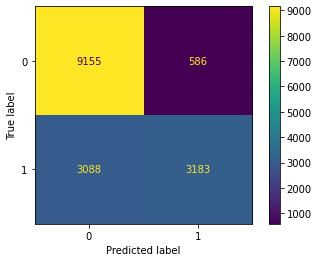

In [ ]:
# TEST DATA
# score
print('Testing accuracy for RFC: '+str(xgb_clf.score(X_test, y_test) ))
# confusion matrix
plot_confusion_matrix(model_LR,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['0','1'])

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, xgb_clf.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

# ROC AUC
print('XGB: ROC AUC = %.3f' % (roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])))

# IR & BR together

In [ ]:
# create X
X2 = np.array(df[['IR','BR']])
scaler = MinMaxScaler()
X2 = scaler.fit_transform(X2)
print(X2.shape)

# create y
y = np.array(df['Label'])
y.shape

(80060, 2)


(80060,)

In [ ]:
# divide data into training and test split
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=15, stratify=y)

print(X_train.shape)
print(X_test.shape)
# check for distribution of y
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

(64048, 2)
(16012, 2)
0.3916125405945541
0.391643767174619


## Logistic Regression

In [ ]:
# Grid Search for optimal parameters with CV
# round1
parameter_grid = {
              'C': [0.001,0.01,0.1,1,10,50,100,500]
}

grid = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=parameter_grid,verbose=2, n_jobs=10, cv = 5
)

grid.fit(X_train, y_train)
print("Best accuracy: %f with params %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    6.4s


Best accuracy: 0.826974 with params {'C': 100}


[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:    8.0s finished


In [ ]:
# train and fit model
model_LR = LogisticRegression(C = 100)
model_LR.fit(X_train, y_train)
print("Traning accuracy for Linear Regression: {}".format(model_LR.score(X_train, y_train)))

Traning accuracy for Linear Regression: 0.8270047464401699


Testing accuracy: 0.8273170122408194
Sensitivity = 0.6868123106362621
Specificity = 0.9177702494610409
Logistic Regression: ROC AUC = 0.891


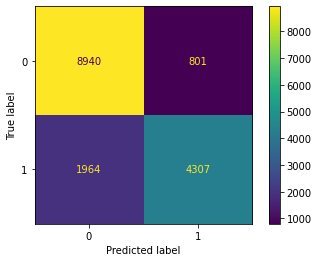

In [ ]:
# TEST DATA
# score
print('Testing accuracy: '+str(model_LR.score(X_test, y_test) ))
# confusion matrix
plot_confusion_matrix(model_LR,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['0','1'])

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, model_LR.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

# ROC AUC
print('Logistic Regression: ROC AUC = %.3f' % (roc_auc_score(y_test, model_LR.predict_proba(X_test)[:, 1])))

## SVC

In [ ]:
# Grid Search for optimal parameters with CV
pipe_classifier = Pipeline([('scaler',  StandardScaler()),
            ('SVC', svm.SVC())])
parameter_grid = [{
              'SVC__C': [0.1, 0.5, 1], 
              'SVC__kernel': ['rbf', 'linear'],
              'SVC__gamma': [0.01,0.1,'auto',10]
}]


grid = GridSearchCV (estimator = pipe_classifier,
                               param_grid = parameter_grid,
                               scoring='roc_auc',cv = 5, verbose=2, n_jobs=10)
grid.fit(X_train, y_train)
print("Best score AUC: %f with params %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 16.6min
[Parallel(n_jobs=10)]: Done 120 out of 120 | elapsed: 88.4min finished


Best score AUC: 0.888128 with params {'SVC__C': 1, 'SVC__gamma': 0.01, 'SVC__kernel': 'linear'}


In [ ]:
# train and fit model
svc = svm.SVC(C=1, gamma=0.01,kernel='linear', probability=True)
svc.fit(X_train, y_train)
print("Traning accuracy for SVC: {}".format(svc.score(X_train, y_train)))

Traning accuracy for SVC: 0.8260367224581564


Testing accuracy for SVC: 0.8263177616787409
Sensitivity = 0.6826662414287993
Specificity = 0.9187968381069705
SVC: ROC AUC = 0.891


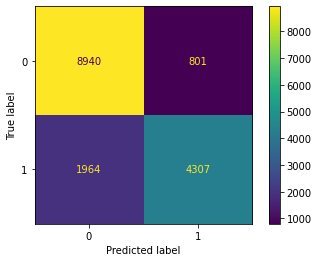

In [ ]:
# TEST DATA
# score
print('Testing accuracy for SVC: '+str(svc.score(X_test, y_test) ))
# confusion matrix
# confusion matrix
plot_confusion_matrix(model_LR,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['0','1'])

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, svc.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

# ROC AUC
print('SVC: ROC AUC = %.3f' % (roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1])))

## Random Forest

In [ ]:
# Grid Search for optimal parameters with CV
# round1
parameter_grid = {
              'n_estimators': [10,25,50,75,100], 
              'max_depth': [1,2,3,4,5]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=parameter_grid,
    scoring='roc_auc', verbose=2, n_jobs=10, cv = 5
)

grid.fit(X_train, y_train)
print("Best score AUC: %f with params %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   21.5s
[Parallel(n_jobs=10)]: Done 125 out of 125 | elapsed:  2.6min finished


Best score AUC: 0.887028 with params {'max_depth': 5, 'n_estimators': 100}


In [ ]:
# train and fit model
rfc = RandomForestClassifier(n_estimators=100, max_depth=5)
rfc.fit(X_train, y_train)

print("Traning accuracy for Random Forest: {}".format(rfc.score(X_train, y_train)))

Traning accuracy for Random Forest: 0.8300181114164377


Testing accuracy:  0.832063452410692
Sensitivity = 0.7333758571200766
Specificity = 0.8955959347089621
RFC: ROC AUC = 0.889


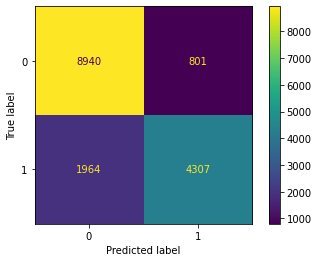

In [ ]:
# TEST DATA
# score
print('Testing accuracy:  '+str(rfc.score(X_test, y_test) ))
# confusion matrix
plot_confusion_matrix(model_LR,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['0','1'])
# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, rfc.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

# ROC AUC
print('RFC: ROC AUC = %.3f' % (roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])))

## XGBoost

In [ ]:
# Grid Search for optimal parameters with CV
# round1
parameter_grid = {
              'learning_rate': [0.1, 0.5, 1], 
              'max_depth': [2,4,6,8],
              'gamma': [0, 1, 5],
              'reg_lambda': [0, 1.0, 10.0],
}

grid = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=15,
                                subsample=0.8,
                                ),
    param_grid=parameter_grid,
    scoring='roc_auc', 
    verbose=2, #0 otherwise
    n_jobs=10,
    cv = 5
)

grid.fit(X_train, y_train)
print("Best score AUC: %f with params %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   49.1s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  5.8min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed: 14.2min
[Parallel(n_jobs=10)]: Done 540 out of 540 | elapsed: 22.2min finished


Best score AUC: 0.889348 with params {'gamma': 5, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 1.0}


In [ ]:
# training and fitting model
xgb_clf = xgb.XGBClassifier(seed=15, objective='binary:logistic', subsample=0.8,                      
                            gamma=5, learning_rate=0.1, max_depth=4, reg_lambda=1.0)
xgb_clf.fit(X_train, y_train)        

print("Traning accuracy for XGBoost: {}".format(xgb_clf.score(X_train, y_train)))

Traning accuracy for XGBoost: 0.8308924556582563


Testing accuracy for RFC: 0.832687984011991
Sensitivity = 0.7324190719183543
Specificity = 0.8972384765424495
XGB: ROC AUC = 0.892


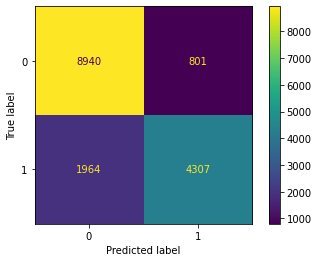

In [ ]:
# TEST DATA
# score
print('Testing accuracy for RFC: '+str(xgb_clf.score(X_test, y_test) ))
# confusion matrix
plot_confusion_matrix(model_LR,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['0','1'])

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, xgb_clf.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

# ROC AUC
print('XGB: ROC AUC = %.3f' % (roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])))